In [1]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.2 MB/s eta 0:00:00


Install libraries

In [2]:
import pandas as pd
import io
from google.colab import files
from bertopic import BERTopic

Load data

In [7]:
#load data
uploaded = files.upload()


Saving new_kc_osm.csv to new_kc_osm.csv


In [6]:
#load osm data for kc
kc_osm_dbscan_tag= pd.read_csv(io.BytesIO(uploaded_1['kc_osm_dbscan_tag_oct.csv']))
osm_kc = kc_osm_dbscan_tag['value'].tolist()


In [8]:
##calling the saved kc_osm data from the folder
#load osm data for KC
kc_osm_data= pd.read_csv(io.BytesIO(uploaded['new_kc_osm.csv']))
#convert to geopandas dataframe
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data['geometry.coordinates'] = kc_osm_data['geometry.coordinates'].apply(lambda x: Point(eval(x)))
kc_osm_data = gpd.GeoDataFrame(kc_osm_data, geometry = 'geometry.coordinates', crs="EPSG:27700")

<ipython-input-8-722f33201d9b>:3: DtypeWarning: Columns (8,11,24,31,46,53,62,67,68,77,79,81,82,83,84,85,86,87,89,91,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,144,145,146,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,259,260,261,262,263,265,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,293,294,295,296,297,298,299,300,301,303,304,305,307,309,310,311,312,314,316,317,318,319,320,321,322,323,325,326,327,328,329,330,331

<Axes: >

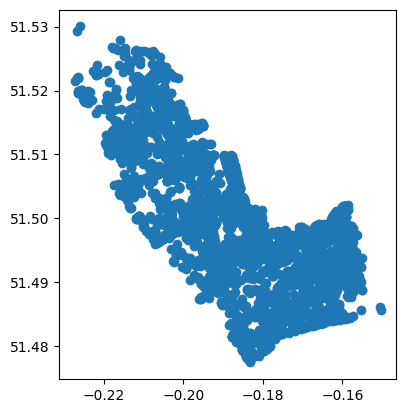

In [9]:
#Melt the dataframe
value_vars = ['properties.amenity', 'properties.healthcare', 'properties.office', 'properties.historic', 'properties.natural',
              'properties.shop', 'properties.tourism', 'properties.leisure', 'properties.sport', 'properties.aeroway', 'properties.man_made',
              'properties.waterway']
id_vars = [x for x in kc_osm_data.columns if x not in value_vars]
kc_osm_data2 = pd.melt(kc_osm_data,
                       id_vars=id_vars,
                       value_vars=value_vars,
                       var_name= 'key',
                       value_name= 'value')
#remove none values from tags
kc_osm_data2 = kc_osm_data2.dropna(subset=['value'])
#select certain columns
kc_osm_data2 = kc_osm_data2[["geometry.coordinates", "properties.@osmId", "key", "value"]]
#convert to geopandas dataframe
from shapely.geometry import Point
from geopandas import GeoDataFrame
kc_osm_data2['geometry.coordinates'] = kc_osm_data2['geometry.coordinates'].apply(Point)
#plot the data
kc_osm_data2 = gpd.GeoDataFrame(kc_osm_data2, geometry = 'geometry.coordinates', crs="EPSG:4326")
kc_osm_data2.plot()

In [ ]:
#DBSCAN

In [10]:
#Run spatial clustering using DBSCAN
from shapely.geometry import MultiPoint
#remove unnecessary values
kc_osm_data2 = kc_osm_data2[~(kc_osm_data2.value.isin(["yes"]))]
kc_osm_data2['lon'] = kc_osm_data2['geometry.coordinates'].x
kc_osm_data2['lat'] = kc_osm_data2['geometry.coordinates'].y
kc_coords = kc_osm_data2[['lon', 'lat']].to_numpy()

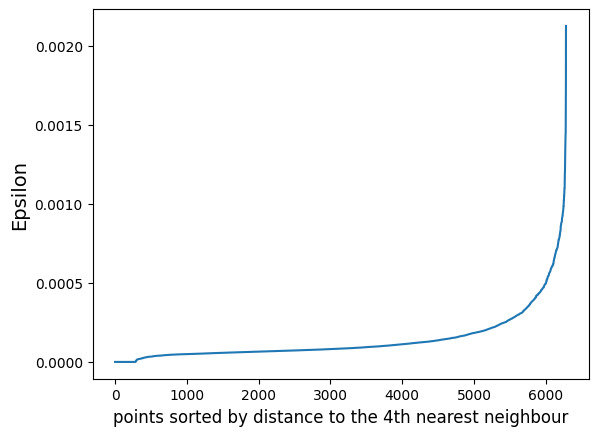

In [11]:
#finding the optimum epsilon
#Codes adopted from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(kc_coords)
#distance between each point and its k nearest neighbour
distances, indices = neighbors_fit.kneighbors(kc_coords)
#sort distances in ascending order
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plot distances
plt.xlabel('points sorted by distance to the 4th nearest neighbour', fontsize=12)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

no. of clusters: 118
no of noise: 474


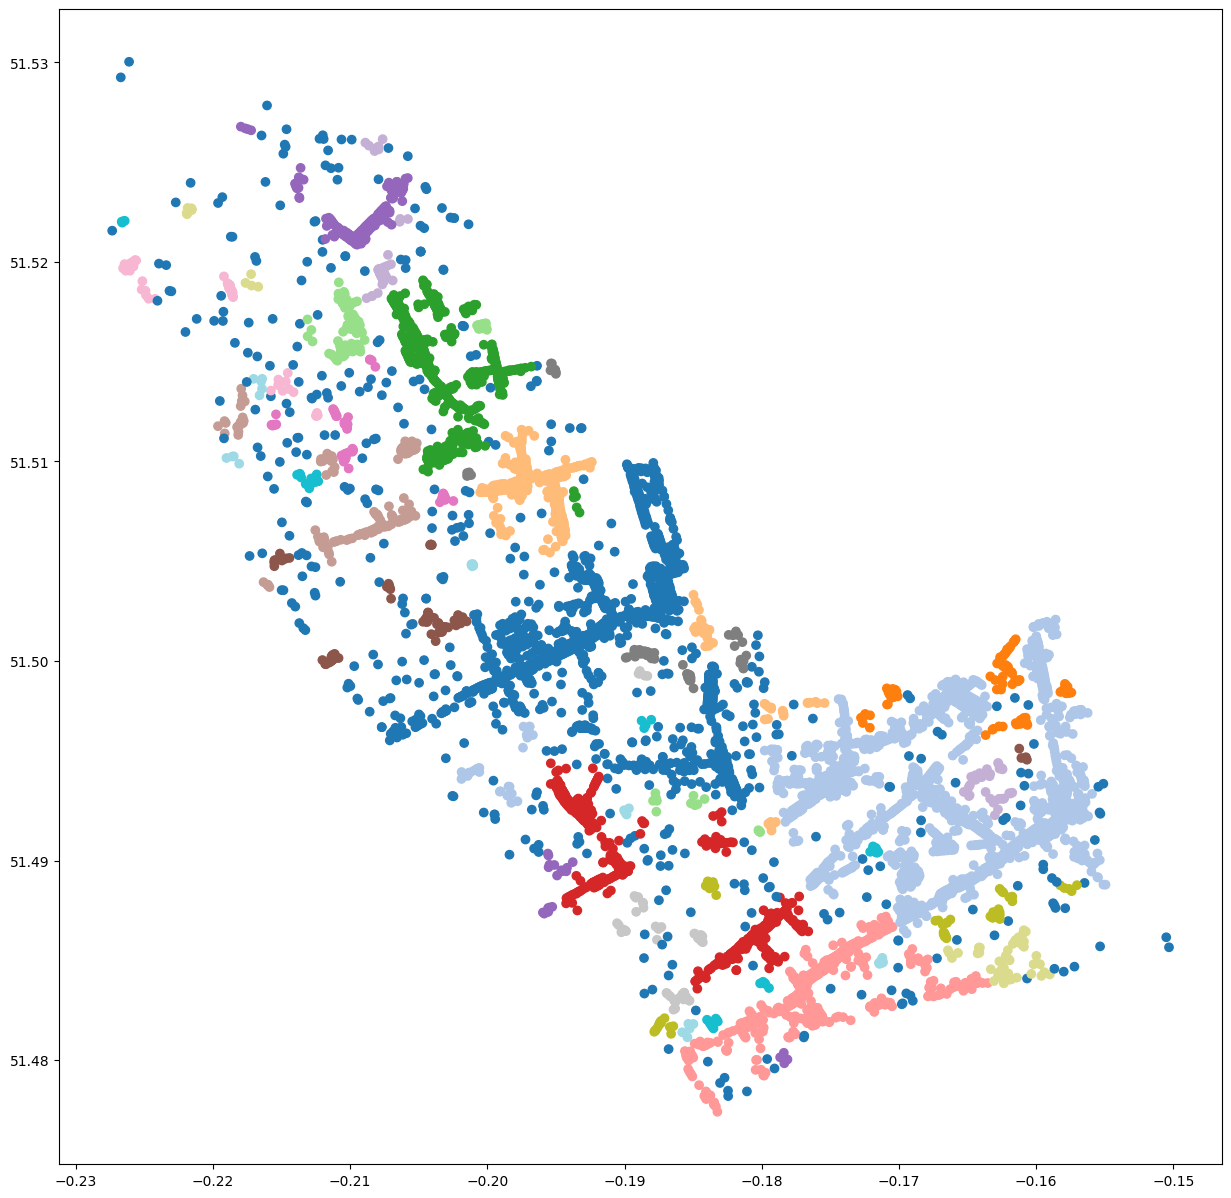

In [12]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0006, min_samples=4) #optimum epsilon 60m
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_osm_data2['cluster'] = dbscan_labels
import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(15, 15))
plt.scatter(kc_osm_data2['lon'],
            kc_osm_data2['lat'],
            c=kc_osm_data2['cluster'],
            cmap='tab20')

In [13]:
#remove noise
remove = kc_osm_data2[kc_osm_data2['cluster'] == -1].index
kc_osm_data3 = kc_osm_data2.drop(remove)
#get tag list for each dbscan cluster as a list
osm_kc_dbscan = kc_osm_data3.groupby('cluster')['value'].apply(list)
data_dbscan = pd.DataFrame(osm_kc_dbscan)
tag_list_dbscan = data_dbscan.value.values.tolist()
data_dbscan

,value
cluster,
0,"[post_box, parking_entrance, dentist, dentist,..."
1,"[bicycle_rental, post_box, telephone, bicycle_..."
2,"[cafe, motorcycle_parking, car_sharing, post_b..."
3,"[post_box, pharmacy, post_box, bicycle_parking..."
4,"[restaurant, telephone, telephone, bicycle_par..."
...,...
112,"[tree, tree, tree, tree, hostel]"
113,"[tree, tree, tree, tree, tree, tree, tree, tree]"
114,"[car_wash, tree, tree, tree, tree]"


[<POLYGON ((-0.203 51.497, -0.201 51.502, -0.19 51.51, -0.188 51.51, -0.188 5...>, <POLYGON ((-0.205 51.497, -0.205 51.497, -0.205 51.497, -0.205 51.497, -0.20...>, <POLYGON ((-0.207 51.496, -0.207 51.496, -0.207 51.497, -0.206 51.497, -0.20...>, <POLYGON ((-0.194 51.496, -0.194 51.496, -0.193 51.497, -0.192 51.497, -0.19...>, <POLYGON ((-0.181 51.493, -0.187 51.493, -0.191 51.495, -0.191 51.495, -0.19...>, <POLYGON ((-0.198 51.493, -0.199 51.493, -0.198 51.494, -0.198 51.494, -0.19...>, <POLYGON ((-0.202 51.494, -0.202 51.494, -0.201 51.495, -0.201 51.494, -0.20...>, <POLYGON ((-0.197 51.496, -0.197 51.497, -0.197 51.497, -0.197 51.496, -0.19...>, <POLYGON ((-0.169 51.486, -0.176 51.489, -0.176 51.489, -0.174 51.492, -0.16...>, <POLYGON ((-0.178 51.492, -0.18 51.496, -0.174 51.498, -0.166 51.499, -0.165...>, <POLYGON ((-0.178 51.491, -0.178 51.491, -0.177 51.491, -0.177 51.491, -0.17...>, <POLYGON ((-0.163 51.499, -0.163 51.499, -0.163 51.499, -0.163 51.5, -0.161 ...>, <POLYGON ((-0.1

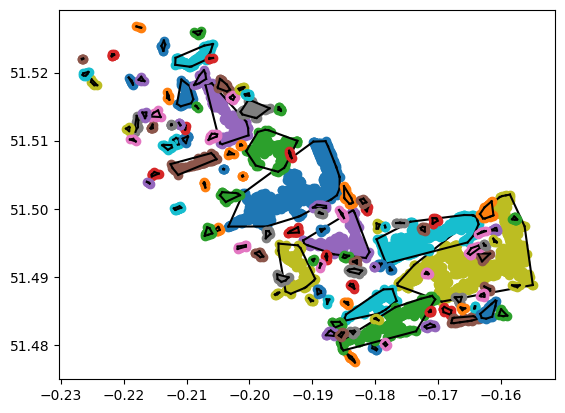

In [25]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = kc_osm_data3[["lon",
                   "lat",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,117):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["lon", "lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)

In [ ]:
#Run BERTopic

In [14]:
#run model
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=5,
                  #n_components=2,
                  min_dist=0.0,
                  metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 4,
                        min_samples = 3,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()

#run model
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        #nr_topics = 8,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)

topics, probs = topic_model.fit_transform(osm_kc)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-11-20 14:02:17,457 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-11-20 14:02:24,069 - BERTopic - Embedding - Completed ✓
2024-11-20 14:02:24,076 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-20 14:02:35,860 - BERTopic - Dimensionality - Completed ✓
2024-11-20 14:02:35,862 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-20 14:02:35,882 - BERTopic - Cluster - Completed ✓
2024-11-20 14:02:35,889 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-20 14:02:35,927 - BERTopic - Representation - Completed ✓


In [16]:
topic_model.visualize_barchart(title = 'Topic word scores for OSM POI tags', top_n_topics =10 )

In [17]:
bertopic_df = pd.DataFrame(topic_model.get_document_info(osm_kc))

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"['clothes', 'fireplace', 'florist', 'jewelry',...",1,1_tree_clothes_restaurant_bicycle_parking,"[tree, clothes, restaurant, bicycle_parking, b...","[['restaurant', 'motorcycle_parking', 'bicycle...",tree - clothes - restaurant - bicycle_parking ...,1.000000,True
1,"['supermarket', 'atm', 'telephone', 'convenien...",6,6_convenience_hairdresser_grit_bin_post_box,"[convenience, hairdresser, grit_bin, post_box,...","[['fast_food', 'fast_food', 'convenience', 'bi...",convenience - hairdresser - grit_bin - post_bo...,0.447087,False
2,"['car_sharing', 'tree', 'tree', 'cafe', 'tree'...",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,0.329088,False
3,"['cafe', 'dry_cleaning', 'greengrocer', 'dry_c...",6,6_convenience_hairdresser_grit_bin_post_box,"[convenience, hairdresser, grit_bin, post_box,...","[['fast_food', 'fast_food', 'convenience', 'bi...",convenience - hairdresser - grit_bin - post_bo...,1.000000,True
4,"['memorial', 'bicycle_rental', 'apartment', 'm...",1,1_tree_clothes_restaurant_bicycle_parking,"[tree, clothes, restaurant, bicycle_parking, b...","[['restaurant', 'motorcycle_parking', 'bicycle...",tree - clothes - restaurant - bicycle_parking ...,0.859666,False
...,...,...,...,...,...,...,...,...
112,"['tree', 'tree', 'tree', 'hostel', 'tree']",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False
113,"['tree', 'tree', 'tree', 'tree', 'tree', 'tree...",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False
114,"['tree', 'tree', 'tree', 'car_wash', 'tree']",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False
115,"['dance', 'waste_basket', 'bicycle_rental', 'w...",-1,-1_waste_basket_bench_bicycle_parking_electrical,"[waste_basket, bench, bicycle_parking, electri...","[['dance', 'waste_basket', 'bicycle_rental', '...",waste_basket - bench - bicycle_parking - elect...,0.474551,True


In [18]:
topic_model.get_topic_freq()

,Topic,Count
2,0,21
0,1,15
3,2,11
5,3,11
7,4,11
4,5,9
1,6,7
10,7,7
9,-1,6
6,8,5


In [19]:
topic_model.generate_topic_labels()

['-1_waste_basket_bench_bicycle_parking',
 '0_tree_post_box_bicycle_parking',
 '1_tree_clothes_restaurant',
 '2_bicycle_parking_clinic_telephone',
 '3_gallery_dentist_post_box',
 '4_memorial_motorcycle_parking_childcare',
 '5_estate_agent_bicycle_parking_motorcycle_parking',
 '6_convenience_hairdresser_grit_bin',
 '7_bench_motorcycle_parking_waste_basket',
 '8_bench_restaurant_artwork',
 '9_interior_decoration_antiques_beauty',
 '10_bench_playground_clock',
 '11_veterinary_fountain_carpet']

In [32]:
#Name the bertopic topics
def get_osm_bertopic_name(Topic):
    if Topic == 0:
        return 'Mixed'
    elif Topic == 1:
        return 'Shopping area'
    elif Topic == 2:
        return 'Residential area '
    elif Topic == 3:
        return 'Tourism and shopping street'
    elif Topic == 4:
        return 'Vehicle Parking Zone'
    elif Topic == 5:
        return 'Mixed'
    elif Topic == 6:
        return 'Local shopping street '
    elif Topic == 7:
        return 'Vehicle Parking Zone'
    elif Topic == 8:
        return 'Food cafe'
    else:
        return 'Antique and Boutique shops'
bertopic_df['BERTopic_OSM'] = bertopic_df['Topic'].apply(get_osm_bertopic_name)


Evaluate Topics

In [33]:
#code adopted from https://github.com/MaartenGr/BERTopic/issues/90
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
documents = pd.DataFrame({"Document": osm_kc,
                          "ID": range(len(osm_kc)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
#words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_uci')
coherence = coherence_model.get_coherence()
coherence

-2.4142858823371163

In [34]:
##add c_h polygon coordinates
bertopic_df['geometry'] = c_h
#set index as column
bertopic_df['cluster'] = bertopic_df.index

In [35]:
bertopic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,BERTopic_OSM,geometry,cluster
0,"['clothes', 'fireplace', 'florist', 'jewelry',...",1,1_tree_clothes_restaurant_bicycle_parking,"[tree, clothes, restaurant, bicycle_parking, b...","[['restaurant', 'motorcycle_parking', 'bicycle...",tree - clothes - restaurant - bicycle_parking ...,1.000000,True,Shopping area,"POLYGON ((-0.203364 51.4973815, -0.2009744 51....",0
1,"['supermarket', 'atm', 'telephone', 'convenien...",6,6_convenience_hairdresser_grit_bin_post_box,"[convenience, hairdresser, grit_bin, post_box,...","[['fast_food', 'fast_food', 'convenience', 'bi...",convenience - hairdresser - grit_bin - post_bo...,0.447087,False,Local shopping street,"POLYGON ((-0.2052432 51.4966829, -0.2054768 51...",1
2,"['car_sharing', 'tree', 'tree', 'cafe', 'tree'...",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,0.329088,False,Mixed,"POLYGON ((-0.2071145 51.4960212, -0.2070454 51...",2
3,"['cafe', 'dry_cleaning', 'greengrocer', 'dry_c...",6,6_convenience_hairdresser_grit_bin_post_box,"[convenience, hairdresser, grit_bin, post_box,...","[['fast_food', 'fast_food', 'convenience', 'bi...",convenience - hairdresser - grit_bin - post_bo...,1.000000,True,Local shopping street,"POLYGON ((-0.1938428 51.4964384, -0.1938025 51...",3
4,"['memorial', 'bicycle_rental', 'apartment', 'm...",1,1_tree_clothes_restaurant_bicycle_parking,"[tree, clothes, restaurant, bicycle_parking, b...","[['restaurant', 'motorcycle_parking', 'bicycle...",tree - clothes - restaurant - bicycle_parking ...,0.859666,False,Shopping area,"POLYGON ((-0.1814931 51.4927648, -0.1866066 51...",4
...,...,...,...,...,...,...,...,...,...,...,...
112,"['tree', 'tree', 'tree', 'hostel', 'tree']",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False,Mixed,"POLYGON ((-0.1898503 51.4923066, -0.1900369 51...",112
113,"['tree', 'tree', 'tree', 'tree', 'tree', 'tree...",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False,Mixed,"POLYGON ((-0.1714266 51.4848246, -0.1714626 51...",113
114,"['tree', 'tree', 'tree', 'car_wash', 'tree']",0,0_tree_post_box_bicycle_parking_bicycle_rental,"[tree, post_box, bicycle_parking, bicycle_rent...","[['tree', 'tree', 'tree', 'tree', 'tree', 'tre...",tree - post_box - bicycle_parking - bicycle_re...,1.000000,False,Mixed,"POLYGON ((-0.216609 51.5133124, -0.21704 51.51...",114
115,"['dance', 'waste_basket', 'bicycle_rental', 'w...",-1,-1_waste_basket_bench_bicycle_parking_electrical,"[waste_basket, bench, bicycle_parking, electri...","[['dance', 'waste_basket', 'bicycle_rental', '...",waste_basket - bench - bicycle_parking - elect...,0.474551,True,Antique and Boutique shops,"POLYGON ((-0.1854205 51.4811451, -0.1858025 51...",115


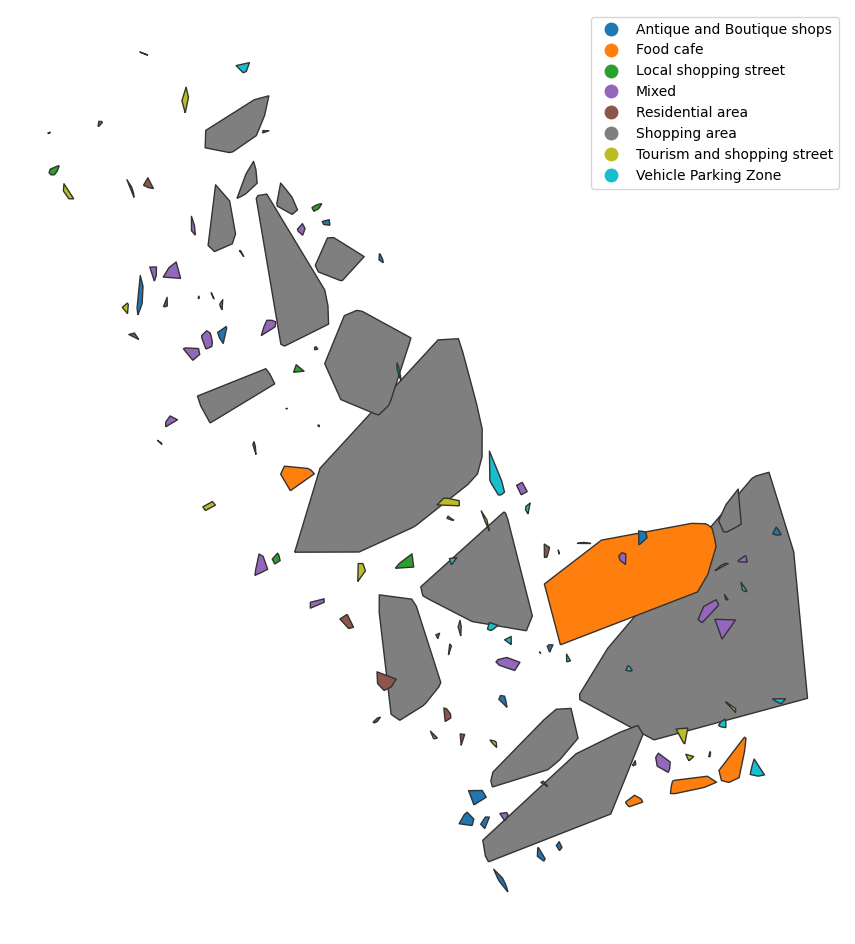

In [36]:
#Mapping
bertopic_gdf = gpd.GeoDataFrame(bertopic_df, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
#kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 12))
#kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  #color= 'lightgrey', alpha= 0.2,
                                  #edgecolor = '0.5')
bertopic_gdf.plot(column='BERTopic_OSM',
                      categorical = True  ,
                      edgecolor='0.2',
                      cmap='tab10',
                      ax=ax,
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()